In [3]:
import cv2
import numpy as np
import pandas as pd
import time
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import transforms,utils

#%matplotlib inline

# Important

 1. Make sure to copy the "data" & "images" folders into your actual notebook directory or add `"Original Training Notebooks/"` before location for datasets and images.
 2. If running on local GPU, try to minimize batch size OR comment the `device = "cuda"` line from `trainNetwork` function
 3. Haar Cascade Checkpoint needs to be downlaoded from OpenCV repo, link is given near the haar cascade module


# Visualization Functions

`plotKeypoints` : will plot actual and predicted keypoints on image

`plot_sample_images` : given PyTorch DataLoader object (train, test, validation loaders) and model it will plot keypoints on first 10 images

In [4]:
def plotKeypoints(image, keypoints, keypoints_green = None):
    """ Plot keypoints on given numpy image

    Arguments:
    #   image (numpy array): Image which needs to be plotted
    #   keypoints (numpy array): (64x2) co-ordinates (x,y) of facial keypoints which needs to be plotted on image (in purple color)
    #   keypoints_green (numpy array): (64x2) co-ordinates (x,y) of facial keypoints which needs to be plotted on image (in green color)
    
    """
    #plt.figure(figsize=(6,6))
    print(image.shape)
    plt.imshow(image, cmap="gray")
    plt.scatter(keypoints[:,0],keypoints[:,1], s = 30, marker=".",c="m")
    if keypoints_green is not None:
        plt.scatter(keypoints_green[:,0],keypoints_green[:,1], s = 30, marker=".",c="g")
    plt.show()


def plot_sample_images(data_loader, model, show_images = 10):
    for i, sample in enumerate(data_loader):
        images = sample["image"]
        keypoints = sample["keypoints"]
        images = images.type(torch.FloatTensor)
        output_keypoints = model(images)
        output_keypoints = output_keypoints.view(output_keypoints.size()[0],68,-1)
        
        for index in range(show_images):
            
            # convert image data to numpy and tranpose it from torch to numpy 
            numpy_image = images[index].data.numpy()
            numpy_image = np.transpose(numpy_image,(1,2,0))
            numpy_image = np.squeeze(numpy_image)
            
            # denormalize the keypoints
            numpy_output_keypoints = output_keypoints[index].data.numpy()
            numpy_output_keypoints = numpy_output_keypoints*50+100
            
            # denormalize actual keypoints
            numpy_actual_keypoints = keypoints[index].data.numpy()
            numpy_actual_keypoints = numpy_actual_keypoints*50+100
            
            plotKeypoints(numpy_image, numpy_output_keypoints, numpy_actual_keypoints)
        
        if(i==0):
            break

In [3]:
class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].to_numpy()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

In [5]:
#=========================================================================
# Net Class which will create a CNN for generating keypoints.
#=========================================================================

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1,32,5)
        # O/P = (224-5)/1 + 1 = 220, (32,220,220)
        
        self.pool1 = nn.MaxPool2d(2,2)
        # O/P = (W - F)/S + 1 = (220 - 2)/2 + 1 = (32,110,110)
        
        self.conv2 = nn.Conv2d(32,64,3)
        # O/P = (110-3)/1 + 1 = 108, (64,108,108)
        
        self.pool2 = nn.MaxPool2d(2,2)
        # O/P = (W - F)/S + 1 = (108 - 2)/2 + 1 = (64,54,54)

        self.conv3 = nn.Conv2d(64,128,3)
        # O/P = (54-3)/1 + 1 = 52, (64,52,52)
        
        self.pool3 = nn.MaxPool2d(2,2)
        # O/P = (W - F)/S + 1 = (52 - 2)/2 + 1 = (128,26,26)

        self.conv4 = nn.Conv2d(128,256,3)
        # O/P = (26-3)/1 + 1 = 24, (64,24,24)
        
        self.pool4 = nn.MaxPool2d(2,2)
        # O/P = (W - F)/S + 1 = (24 - 2)/2 + 1 = (256,12,12)
                                      
        self.fc1 = nn.Linear(256*12*12,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,136)

        self.conv1_drop = nn.Dropout(p = 0.5)
        self.conv2_drop = nn.Dropout(p = 0.4)
        self.conv3_drop = nn.Dropout(p = 0.3)
        self.conv4_drop = nn.Dropout(p = 0.2)

        self.fc1_drop = nn.Dropout(p = 0.4)
        self.fc2_drop = nn.Dropout(p = 0.2)
        
        
    def forward(self, x):
        
        x = self.conv1_drop(self.pool1(F.relu(self.conv1(x))))
        x = self.conv2_drop(self.pool2(F.relu(self.conv2(x))))
        x = self.conv3_drop(self.pool3(F.relu(self.conv3(x))))
        x = self.conv4_drop(self.pool4(F.relu(self.conv4(x))))
        
        x = x.view(x.size(0),-1)
        
        x = self.fc1_drop(F.relu(self.fc1(x)))
        x = self.fc2_drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


def save_checkpoint(model,fileLocation):
  # save the current state_dict which contains all the weights of the network
  torch.save(model.state_dict(),fileLocation)


In [6]:
def trainNetwork(model,epochs,print_interval,criterion,optimizer):
    start_time = time.time()
    iteration = []
    training_loss = []
    validation_loss = []
    minimum_validation_loss = np.Inf
    count = 0
    
    # check if gpu is available, otherwise use cpu for training
    device = "cpu"
    if (torch.cuda.is_available):
        print("Training on GPU")
        device = "cuda"
    
    model.to(device)
    model.train()
    for i in range(epochs):
        for data in train_loader:
            count += 1
            
            images = data["image"]
            keypoints = data["keypoints"]
            
            # Flatten keypoints
            keypoints = keypoints.view(keypoints.size(0), -1)

            # convert variables to floats for regression loss
            keypoints = keypoints.type(torch.FloatTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)
            
            # Forward Pass
            output = model(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output, keypoints)
            
            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
            
            
            if(count%print_interval==0):
                model.eval()
                temp_losses = []
                # valid here is short for validation
                for valid_data in validation_loader:
                    images = valid_data["image"]
                    keypoints = valid_data["keypoints"]

                    # Flatten keypoints
                    keypoints = keypoints.view(keypoints.size(0), -1)

                    # convert variables to floats for regression loss
                    keypoints = keypoints.type(torch.FloatTensor).to(device)
                    images = images.type(torch.FloatTensor).to(device)

                    # Forward Pass
                    output = model(images)

                    # calculate the loss between predicted and target keypoints
                    valid_loss = criterion(output, keypoints)
                    temp_losses.append(valid_loss.item())
            
            # put model back to training mode
                model.train()
            
                print("Epoch: {}\tIteration: {}\tTraining Loss: {:.7f}\tValidation Loss: {:.7f}".format(
                    (i+1),count,loss.item(),np.mean(temp_losses)))
                iteration.append(count)
                training_loss.append(loss.item())
                validation_loss.append(np.mean(temp_losses))
        
                if np.mean(temp_losses)<minimum_validation_loss:
                    save_checkpoint(model,"saved_models/checkpoint.pth")
                    minimum_validation_loss=np.mean(temp_losses)
                    print("Validation loss decreased  hence saving checkpoint successfully")
            
    plt.plot(iteration,training_loss)
    plt.plot(iteration,validation_loss)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.ylim(0.0,1.0)
    plt.legend(['Training Loss','Validation Loss'], loc='upper left')
    plt.show()
    print("Total Training Time(mins): ",((time.time()-start_time)/60))

    # Move model back to CPU before turning
    model.to("cpu")
    return model

In [11]:
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
train_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)


print("Number of images in Train Dataset before split: ",len(train_dataset))

# Out of 100% of train data, use 90% for training and 10% for validation, we have small dataset, otherwise would have used 20% for validation
# Making sure that sum of values euqal to total size of dataset, hence added (int(0.9*len(train_dataset)), int(0.1*len(train_dataset))+1)
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, (int(0.9*len(train_dataset)), int(0.1*len(train_dataset))+1))

print('Number of images in Train Dataset after split: ', len(train_dataset))
print('Number of images in Validation Dataset after split: ', len(validation_dataset))
print('Number of images in Test Dataset: ', len(test_dataset))


# make sure the sample tensors are the expected size
for i in range(2):
    sample = train_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images in Train Dataset before split:  3462
Number of images in Train Dataset after split:  3115
Number of images in Validation Dataset after split:  347
Number of images in Test Dataset:  770
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [12]:
# Create dataloaders for training, testing, validation
batch_size = 64

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

validation_loader = DataLoader(validation_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

# Initialize the network and define loss and optimizer (with hyperparameters)


Here mean squared error might amplify some few random noises, so L1 or Smooth L1 loss function might fit more well, we can see it by experimenting. 

In [16]:
net = Net()

criterion = nn.L1Loss()
optimizer = optim.Adam(params = net.parameters(),lr = 0.001)

# Visualizing few training images with untrained model

Visualize few samples by passing model and train data into the plot function which will run forward pass on model and plot the keypoints for images in "purple" color and actual points will be plotted in "green" color. 

Since model is not trained at this moment, we will see that purple points will not fit anywehere near actual keypoints.

(224, 224)


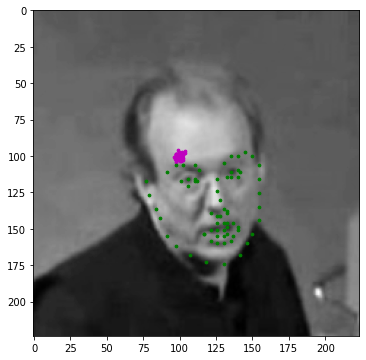

(224, 224)


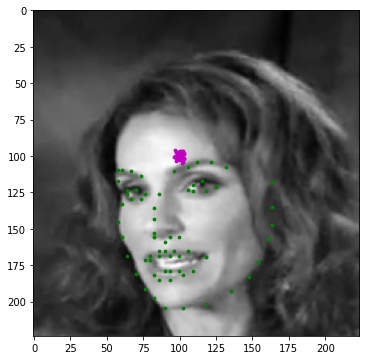

(224, 224)


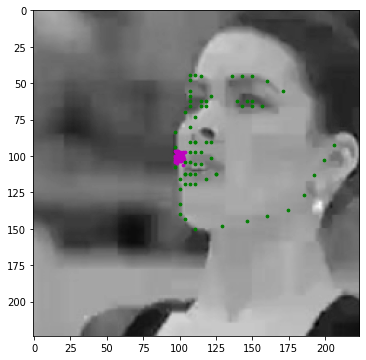

(224, 224)


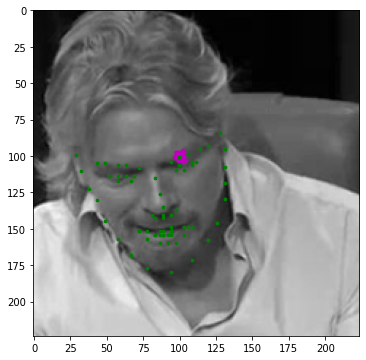

(224, 224)


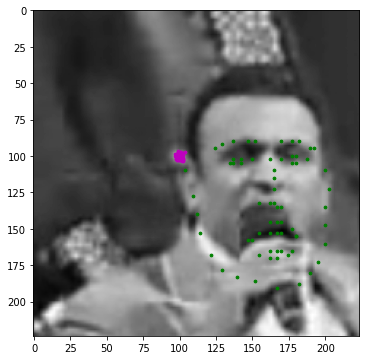

(224, 224)


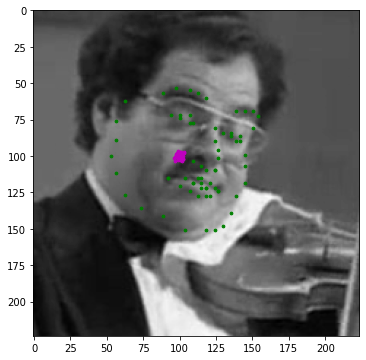

(224, 224)


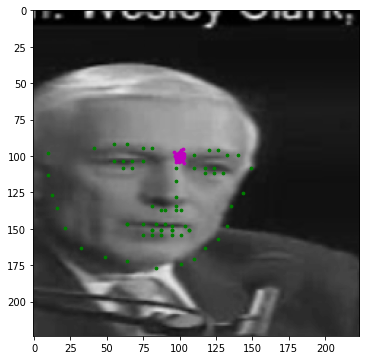

(224, 224)


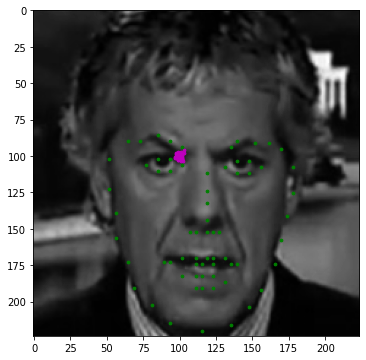

(224, 224)


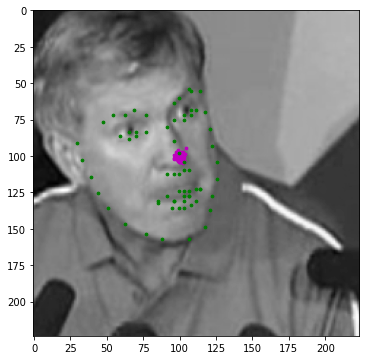

(224, 224)


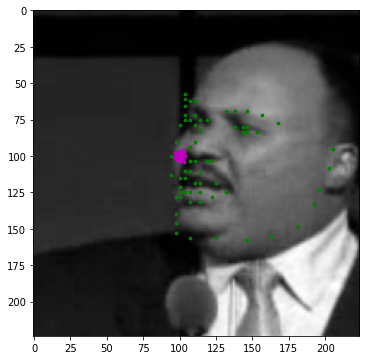

In [12]:
plot_sample_images(train_loader, net)

# Train the network

Training on GPU
Epoch: 1	Iteration: 20	Training Loss: 0.3749847	Validation Loss: 0.3942194
Validation loss decreased  hence saving checkpoint successfully
Epoch: 1	Iteration: 40	Training Loss: 0.3271166	Validation Loss: 0.3567310
Validation loss decreased  hence saving checkpoint successfully
Epoch: 2	Iteration: 60	Training Loss: 0.3382839	Validation Loss: 0.3607896
Epoch: 2	Iteration: 80	Training Loss: 0.3236377	Validation Loss: 0.3403607
Validation loss decreased  hence saving checkpoint successfully
Epoch: 3	Iteration: 100	Training Loss: 0.3425840	Validation Loss: 0.3359292
Validation loss decreased  hence saving checkpoint successfully
Epoch: 3	Iteration: 120	Training Loss: 0.2864260	Validation Loss: 0.3042855
Validation loss decreased  hence saving checkpoint successfully
Epoch: 3	Iteration: 140	Training Loss: 0.3052938	Validation Loss: 0.3251143
Epoch: 4	Iteration: 160	Training Loss: 0.2786757	Validation Loss: 0.3115304
Epoch: 4	Iteration: 180	Training Loss: 0.3037865	Validation 

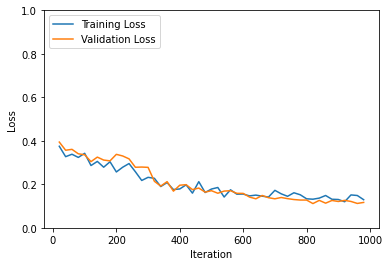

Total Training Time(mins):  5.685007651646932


In [18]:
net = trainNetwork(net,20,20,criterion,optimizer)

# After training, visualize the test images with model's output

Depending on how well network was trained, we should be able to see keypoints mapped more closer to actual keypoints. Since this is a regression related task, we cannot actually print accuracy of network. Rather loss value gives us idea about it.

(224, 224)


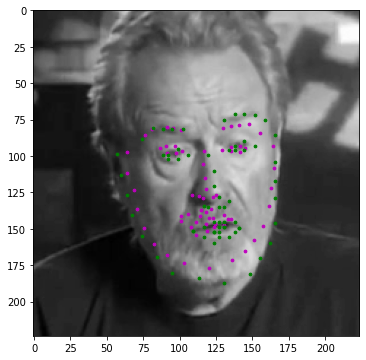

(224, 224)


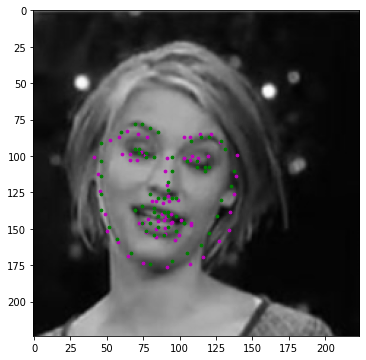

(224, 224)


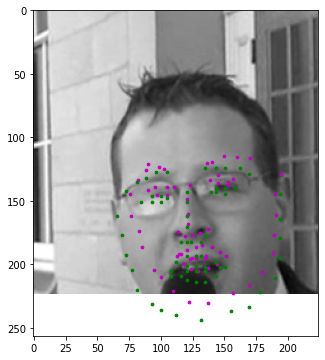

(224, 224)


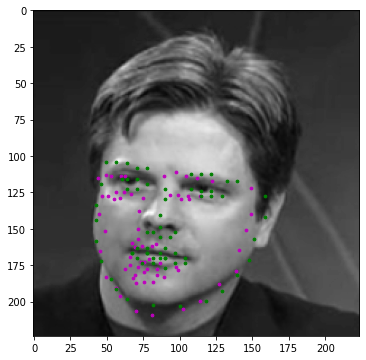

(224, 224)


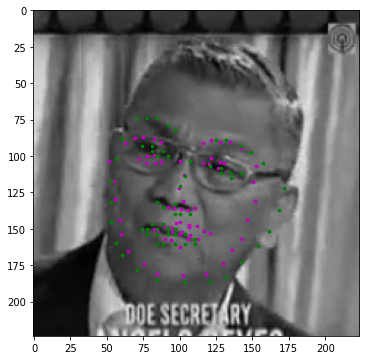

(224, 224)


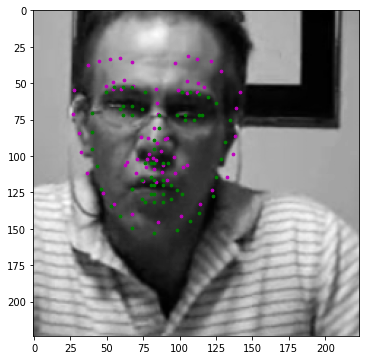

(224, 224)


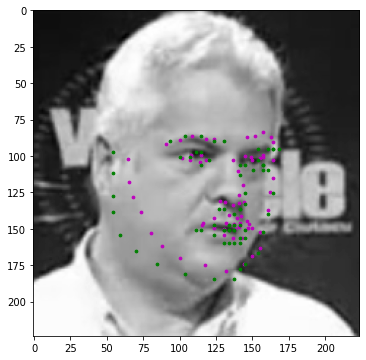

(224, 224)


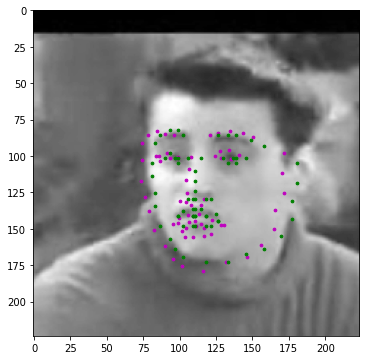

(224, 224)


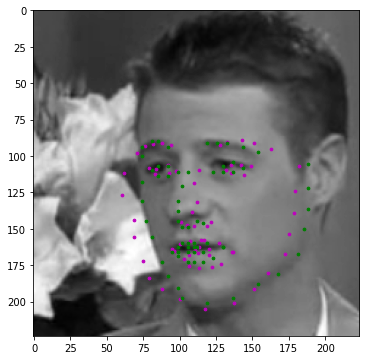

(224, 224)


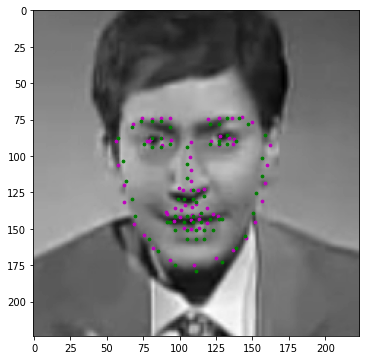

In [19]:
plot_sample_images(test_loader, net)

# Compare it with the saved model

In training loop, whenever validation loss decreased, the model checkpoint was saved. Loading that model and running the same test images on that will help compare result form current running model (which wasn't saved)

It can be seen that saved model is slight better. Hence that checkpoint can be used. Alternatively model can be trained for few more epochs

In [7]:
savedNet = Net()
savedNet.load_state_dict(torch.load("saved_models/checkpoint.pth"))

<All keys matched successfully>

(224, 224)


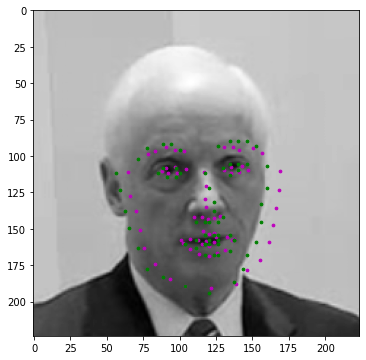

(224, 224)


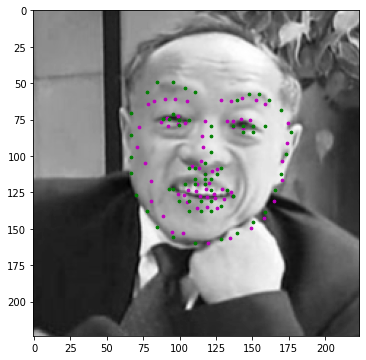

(224, 224)


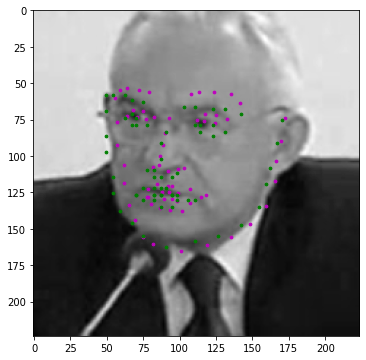

(224, 224)


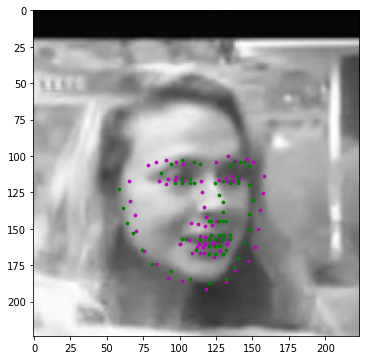

(224, 224)


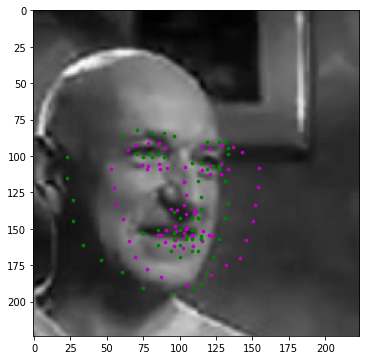

(224, 224)


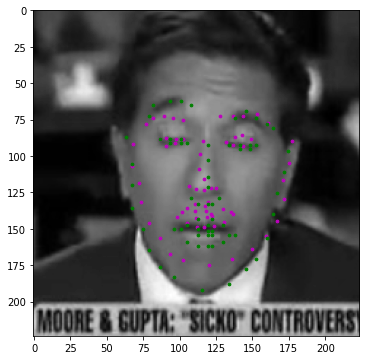

(224, 224)


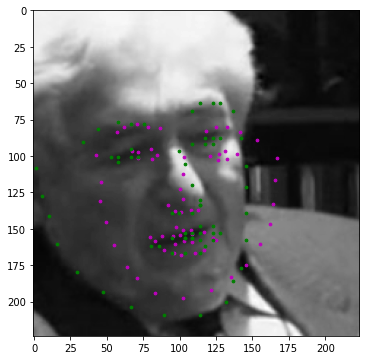

(224, 224)


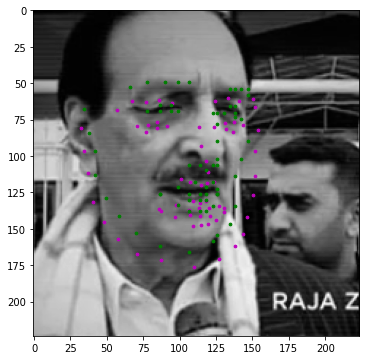

(224, 224)


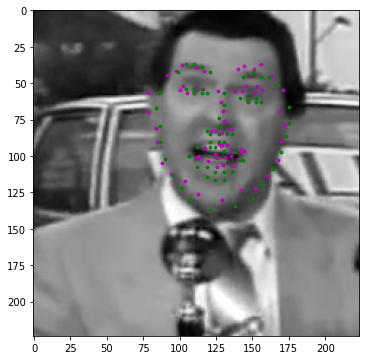

(224, 224)


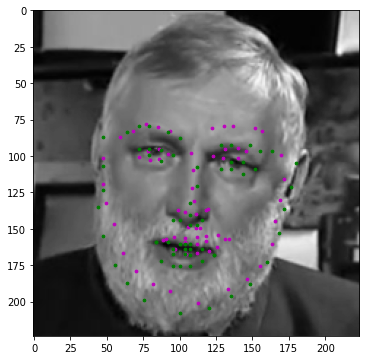

In [21]:
plot_sample_images(test_loader, savedNet)

# Combine Haar Casade with CNN Output for Plotting Keypoints

After the model has been trained
 -> Haar Cascade can be used to first crop out the detected faces from image
 -> Then faces will be fed into CNN for getting corresponding keypoints
 -> Once done we can translate the keypoints back to original image size and save it
 
 *Checkpoint for Haar Cascade:* https://github.com/opencv/opencv/tree/master/data/haarcascades
  
 *Example Use:* https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html

In [8]:
HAAR_CASCADE_CHECKPOINT = "detector_architectures/haarcascade_frontalface_default.xml"

def getDetectedFaces(image_path):
    face_cascade = cv2.CascadeClassifier(HAAR_CASCADE_CHECKPOINT)
    img = cv2.imread(image_path)
    rgb_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    detected_img = np.copy(rgb_img)
    faces = face_cascade.detectMultiScale(gray_img,1.5,5)
    for (x,y,w,h) in faces:
        detected_img = cv2.rectangle(detected_img,(x,y),(x+w,y+h),(255,0,0),2)
    return {"Original Image":rgb_img,
            "Gray Image":gray_img,
            "Detected Image":detected_img,
            "Faces":faces}

In [9]:
def regression_predict_keypoints(original_img, gray_img, points,model, save=False, filename=None):
    """ Plots facial keypoints on selected square of gray image and also in orignal image
    
    Arguments:
    #   original_img (numpy array): Original RGB Image
    #   gray_img (numpy array): Gray Image generated from same original iamge
    #   points (numpy array): (x,y,w,h) for face box generated by open cv2 haar cascade
    #   save (boolean): Optional argument if original RGB image needs to be saved with plotted points
    #   filename (string): If image needs to be saved, filename of output image
    
    """
    x,y,w,h = points[0],points[1],points[2],points[3]
           
    gray_img = gray_img[y:y+h,x:x+w]
    
    # Will be used later to scale up points to original image
    original_square_size = gray_img.shape[0]
    #print(original_square_size)
        
    gray_img = gray_img/255
    gray_img = cv2.resize(gray_img, (224,224), interpolation = cv2.INTER_AREA)
    
    copied_gray_img = np.copy(gray_img)
    
    input_tensor = torchvision.transforms.ToTensor()(gray_img)
    input_tensor = input_tensor.unsqueeze(0)
    input_tensor = input_tensor.type(torch.FloatTensor)
    
    keypoints = model(input_tensor)
    
    keypoints = keypoints.view(68,2)
    keypoints = keypoints.data.numpy()
    keypoints = keypoints*50.0+100
    
    im = input_tensor.data
    im = im.numpy()
    im = np.transpose(im[0], (1, 2, 0))
    
    # this will plot image on selected square
    plotKeypoints(np.squeeze(im), keypoints)
    
    # to translate back the points to approx original image, we will use scaling factor
    # [[X_new],[Y_new]] = [[Sx,0],[0,Sy]] X [[X_old],[Y_old]]
    # X_Actual = X_new + x (here x is taken from (x,y,w,h) of haar cascade box)
    # Y_Actual = Y_new + y (here y is taken from (x,y,w,h) of haar cascade box)
    
    # Since the cropped face was square, the scale factor Sx and Sy will be same
    scale_ratio = original_square_size/224 
    keypoints = keypoints*scale_ratio
    keypoints[:,0] = keypoints[:,0]+x
    keypoints[:,1] = keypoints[:,1]+y
        
    plotKeypoints(original_img, keypoints)
    
    # if save argument is true then save the original image with keypoints plotted in it, 
    # currently s = 100*scale_ration but it can me made bigger if original image is very high resolution
    # otherwise the dots will not be visible when plotted
    if save:
        dpi = 80
        figsize = (original_img.shape[1]/dpi,original_img.shape[0]/dpi)
        fig = plt.figure(figsize = figsize)
        ax = fig.add_axes([0,0,1,1])
        ax.axis('off')
        ax.imshow(original_img)
        ax.scatter(keypoints[:,0],keypoints[:,1], s = 100*scale_ratio, marker=".",c="m")
        fig.savefig(filename,dpi=dpi,transparent=True)
        plt.close(fig)
    

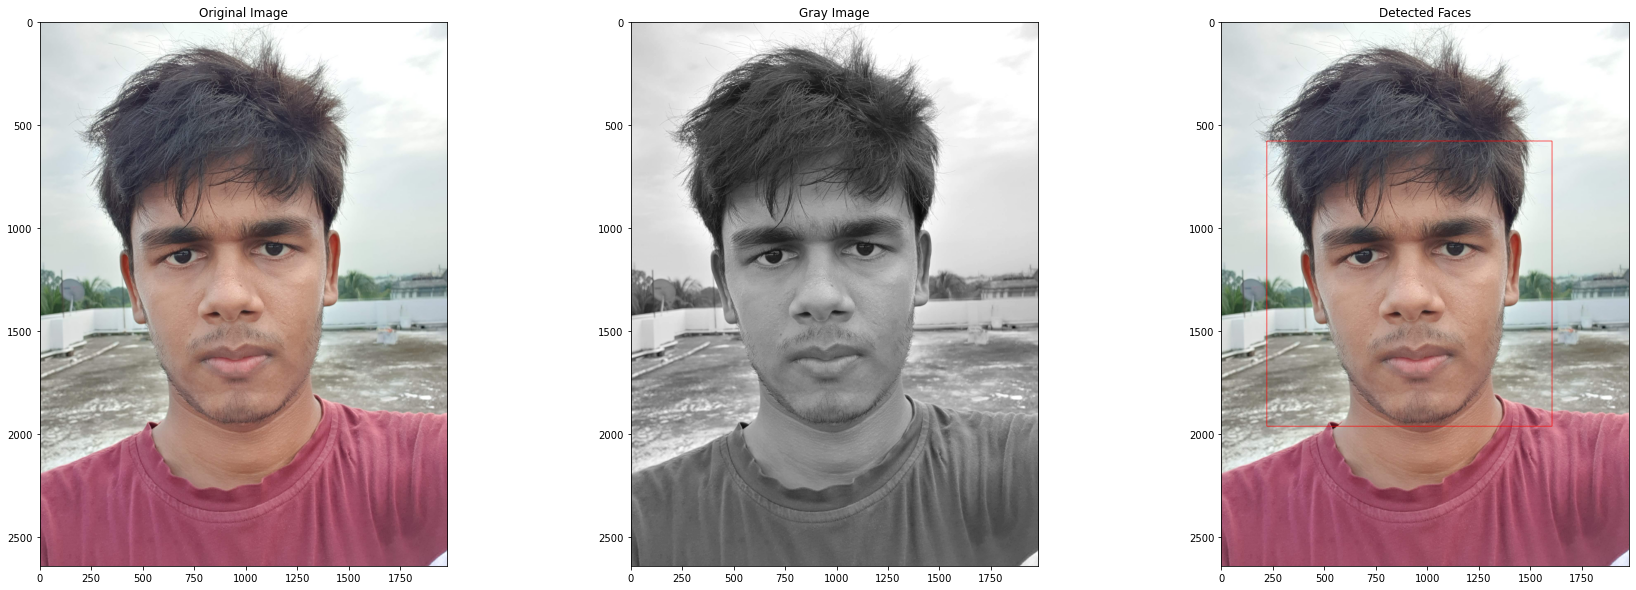

In [10]:
result = getDetectedFaces("images/day.jpg")

f, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(30,10))
ax1.set_title("Original Image")
ax1.imshow(result["Original Image"])

ax2.set_title("Gray Image")
ax2.imshow(result["Gray Image"], cmap="gray")

ax3.set_title("Detected Faces")
ax3.imshow(result["Detected Image"])

plt.show()

(224, 224)


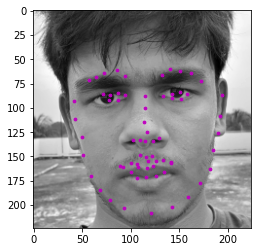

(2640, 1980, 3)


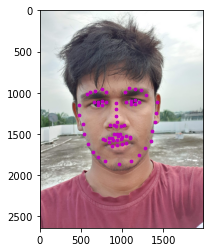

In [19]:
for faces in result["Faces"]:
    regression_predict_keypoints(result["Original Image"],result["Gray Image"],faces,savedNet, save=True,filename="Output.jpg")